# ABS Quarterly National Accounts 5206

Expenditure approach: $GDP(E) = C + I + G + NX$

Income approach: $GDP(I) = CompensationOfEmployees + RentalAndRoyaltyIncome + BusinessCashFlow + NetInterest$

Output or product approach: $GDP(O) = (GrossValueAdded + TaxesOnProducts - SubsidiesOnProducts) - IntermediateConsumption + TaxesOnProducts - SubsidiesOnProducts$

## Python set-up

In [2]:
# system imports
import re
import textwrap
from typing import cast, Any

# analytic imports
import numpy as np
import pandas as pd
import readabs as ra
from readabs import metacol as mc

In [3]:
# local imports
from abs_summary_plot import plot_summary
from abs_helper import (
    get_abs_data,
    ANNUAL_CPI_TARGET_RANGE,
    QUARTERLY_CPI_TARGET,
    get_gdp,
)
from abs_plotting import fix_abs_title
from henderson import hma
from plotting import (
    calc_growth,
    finalise_plot,
    line_plot,
    plot_covid_recovery,
    plot_growth,
    plot_growth_finalise,
    plot_revisions,
)

# pandas display settings
pd.options.display.max_rows = 999999
pd.options.display.max_columns = 999

# display charts within this notebook
SHOW = False
FILE_TYPE = "png"

## Get data from ABS

In [4]:
abs_dict, meta, source, RECENT = get_abs_data("5206.0")
plot_times = None, RECENT
plot_tags = "", "-recent"

# Frequently used names ...
KEY_AGGS = "5206001_Key_Aggregates"
CVM = "Chain volume measures"
VALUE_TEXT = "$ Millions"

In [5]:
# Let's see the spreadsheets we have captured
tw = textwrap.TextWrapper(width=80)
tw.wrap(", ".join(abs_dict.keys()))

['5206001_Key_Aggregates, 5206002_Expenditure_Volume_Measures,',
 '5206003_Expenditure_Current_Price, 5206004_Expenditure_Price_Indexes,',
 '5206005_Expenditure_Implicit_Price_Deflators, 5206006_Industry_GVA,',
 '5206007_Income_From_GDP, 5206008_Household_Final_Consumption_Expenditure,',
 '5206009_Changes_In_Inventories, 5206010_Agricultural_Income,',
 '5206011_National_Income_Account, 5206012_National_Capital_Account,',
 '5206013_NFC_Income, 5206014_PriNFC_Income, 5206015_PubNFC_Income,',
 '5206016_FC_Income, 5206017_Gen_Govt_Income_Account,',
 '5206018_Nat_Gen_Govt_Income_Account, 5206019_StateLocal_Gen_Govt_Income_Account,',
 '5206020_Household_Income, 5206021_External_Account, 5206022_Taxes,',
 '5206023_Social_Assistance_Benefits, 5206024_Selected_Analytical_Series,',
 '5206025_SFD_Summary, 5206026_SFD_NSW, 5206027_SFD_VIC, 5206028_SFD_QLD,',
 '5206029_SFD_SA, 5206030_SFD_WA, 5206031_SFD_TAS, 5206032_SFD_NT,',
 '5206033_SFD_ACT, 5206034_Key_Aggregates_and_Analytical_Series_Annual_d

In [9]:
if False:
    display(meta[meta[mc.did].str.contains("dwelling")])

## Plot

### Summary plot

In [5]:
def summarise() -> None:
    """Summarise the data in the ABS dataset"""

    required = {
        # order from least to most important (ie. bottom to top)
        # chart label: (ABS-code, growth-over-n-periods)
        "1Q growth: Households price deflator": ("A2303940R", 1),
        "4Q growth: Households price deflator": ("A2303940R", 4),
        "1Q growth: GNE price deflator": ("A2303727C", 1),
        "4Q growth: GNE price deflator": ("A2303727C", 4),
        "Household saving ratio": ("A2323382F", 0),
        "1Q growth: GDP per Hour Worked": ("A2304192L", 1),
        "4Q growth: GDP per Hour Worked": ("A2304192L", 4),
        "1Q growth: Hours Worked": ("A2304428W", 1),
        "4Q growth: Hours Worked": ("A2304428W", 4),
        "1Q growth: Household consumption": ("A2304081W", 1),
        "4Q growth: Household consumption": ("A2304081W", 4),
        "1Q growth: GVA market sector": ("A3606056V", 1),
        "4Q growth: GVA market sector": ("A3606056V", 4),
        "1Q growth: GDP/Capita": ("A2304404C", 1),
        "4Q growth: GDP/Capita": ("A2304404C", 4),
        "1Q growth: GDP": ("A2304402X", 1),
        "4Q growth: GDP": ("A2304402X", 4),
    }

    start = "2000Q1"
    plot_summary(
        required,
        abs_dict,
        meta,
        start=start,
        title=f"Key GDP statistics {abs_dict[KEY_AGGS].index[-1]}",
        rfooter=source,
        lfooter="Australia. All values are percentages. "
        "All values are seasonally adjusted. ",
        pre_tag="summary-",
        show=SHOW,
        file_type=FILE_TYPE,
    )


summarise()

Overriding x0: True


### Basic charts, COVID-recovery charts, multi-year growth charts

In [6]:
def wanted_basic_data() -> dict[str, dict[str, str]]:
    """Identify the core data items we want to chart.
    returns a dictionary of items we want to chart in the form:
    {did: {"table": table, "stype": stype, "did": did}}."""

    sa = "Seasonally Adjusted"
    kags, sas = "5206001_Key_Aggregates", "5206024_Selected_Analytical_Series"
    key_cvm_measures = meta.loc[
        (meta[mc.stype] == sa)
        & (
            meta[mc.did].str.contains(CVM)
            & ~(meta[mc.did].str.contains("Percentage"))
            & (meta[mc.table] == kags)
        ),
        mc.did,
    ].tolist()
    wanted = {w: {"table": kags, "stype": sa, "did": w} for w in key_cvm_measures}

    # additional items
    additional = [
        # [label, table, stype]
        ("GDP per hour worked: Index ;", sa, kags),  # Labour productivity
        (
            "Gross value added per hour worked market sector: Index ;",
            sa,
            kags,
        ),  # Labor productivity
        # ["Real unit of labour costs: Index ;", trend, kags),
        # ["Real unit of labour costs - Non-farm: Index ;", trend, kags),
        ("Terms of trade: Index ;", sa, kags),
        ("Public ;  Final demand: Chain volume measures ;", sa, sas),
        ("Private ;  Final demand: Chain volume measures ;", sa, sas),
        (
            "Households ;  Final consumption expenditure - Goods: Chain volume measures ;",
            sa,
            sas,
        ),
        (
            "Households ;  Final consumption expenditure - Services: Chain volume measures ;",
            sa,
            sas,
        ),
        (
            "Households ;  Final consumption expenditure - Essential consumption: Chain volume measures ;",
            sa,
            sas,
        ),
        (
            "Households ;  Final consumption expenditure - Discretionary consumption: Chain volume measures ;",
            sa,
            sas,
        ),
        ("Compensation of employees per hour: Current prices ;", sa, sas),
        ("Non-farm compensation of employees per hour: Current prices ;", sa, sas),
        (
            "Gross fixed capital formation - New private business investment: Chain volume measures ;",
            sa,
            sas,
        ),
    ]
    wanted = wanted | {
        w[0]: {"did": w[0], "stype": w[1], "table": w[2]} for w in additional
    }

    return wanted

In [7]:
def basic_charts(n_years=10) -> None:
    """Produce basic charts for the core data items we want to chart:
    - raw series charts
    - COVID recovery charts
    - quarterly/annual growth rates
    - multi-year (n_years) compound growth rates."""

    twrap = textwrap.TextWrapper(width=60)
    data, data_meta = ra.read_abs_by_desc(
        wanted=wanted_basic_data(),
        abs_dict=abs_dict,
        abs_meta=meta,
    )

    for did_label, series in data.items():
        # remember series.name is the ABS series_id
        units = data_meta.at[series.name, mc.unit]
        series, units = ra.recalibrate(series, units)

        title, lfooter = fix_abs_title(
            did_label, f"Australia. {data_meta.at[series.name, mc.stype]}. "
        )
        ylabel = f"{units}{' / Quarter' if 'hour' not in title and 'Index' not in title else ''}"
        common: dict[str, Any] = {
            "show": SHOW,
            "file_type": FILE_TYPE,
            "y0": True,
            "lfooter": lfooter,
            "rfooter": f"{source} {data_meta.at[series.name, mc.table]}",
        }

        # plot the raw series
        line_plot(
            series,
            dropna=True,
            starts=plot_times,
            tags=plot_tags,
            title=twrap.fill(title),
            ylabel=ylabel,
            pre_tag="basic-as-is-",
            width=2,
            **common,
        )

        # plot the COVID recovery
        plot_covid_recovery(
            series,
            dropna=True,
            title=twrap.fill(f"{title}"),
            ylabel=ylabel,
            pre_tag="basic-covid-",
            **common,
        )

        # plot the Q/A growth rates
        growth = calc_growth(series)
        for start, tag in zip(plot_times, plot_tags):
            plot_growth_finalise(
                *growth,
                from_=start,
                tag=tag,
                title=twrap.fill(f"{title} growth"),
                pre_tag="basic-growth-",
                annotate=9,
                **common,
            )

        # plot the multi-year compound rate annualised
        ax = plot_growth(*growth)
        if ax is None:
            continue
        multi_year_gr = (
            (series / series.shift(periods=n_years * 4) - 1) ** 1 / n_years
        ) * 100
        ax.plot(multi_year_gr.index, multi_year_gr, lw=5, c="white", label="_")
        ax.plot(
            multi_year_gr.index,
            multi_year_gr,
            lw=3,
            c="cornflowerblue",
            label=f"{n_years}-year compound annual growth rate",
        )
        finalise_plot(
            ax,
            title=twrap.fill(f"{n_years}-year Growth: {title}"),
            ylabel="Per cent growth",
            legend={"loc": "best", "fontsize": 9},
            pre_tag=f"basic-growth-{n_years}-",
            **common,
        )


basic_charts()  # takes around 20 seconds to run

### Data revisions

In [8]:
def capture_revisions(did: str, stype: str, how_far_back=6) -> tuple[pd.DataFrame, str]:
    """Capture the revisions for a specified data-item-description (did) and
    seasonal-series-type (stype) for the last how_far_back many quarters.
    Assume the "did" is in the ABS Key Aggregates table for the national accounts."""

    revisions = pd.DataFrame()
    history = None
    catalogue = "5206.0"  # ABS National Accounts catalogue number
    for _i in range(how_far_back):
        # from current to historic data - must be in this order
        data, rev_meta = ra.read_abs_cat(
            catalogue, single_excel_only=KEY_AGGS, history=history
        )
        selector = {did: mc.did, stype: mc.stype}
        table, series_id, units = ra.find_abs_id(rev_meta, selector)
        date = f"ABS print for {data[table].index[-1].strftime("%Y-%b")}"
        revisions[date] = data[table][series_id]
        history = (data[table].index[-1] - 1).strftime("%b-%Y").lower()

    return revisions, units

In [9]:
def data_revisions() -> None:
    """Plot data revisions."""

    dataset = [
        # list of ABS data item descriptions
        "Gross domestic product: Chain volume measures - Percentage changes ;",
        "GDP per capita: Chain volume measures - Percentage changes ;",
        "Gross value added market sector: Chain volume measures - Percentage changes ;",
        "Gross domestic product: Chain volume measures ;",
        "GDP per capita: Chain volume measures ;",
        "Gross value added market sector: Chain volume measures ;",
    ]

    common_plot = {
        "rfooter": source,
        "pre_tag": "revisions",
        "y0": True,
        "show": SHOW,
        "file_type": FILE_TYPE,
    }

    captured = {}
    for did in dataset:
        stype = "Seasonally Adjusted"
        repository, units = capture_revisions(did, stype)
        captured[did] = (repository, units)

        suffix = " Q/Q growth" if "Percentage changes" in did else ""
        plot_revisions(
            data=repository,
            units=units,
            title=f"Data revsions: {re.sub(':.*$', '', did)}{suffix}",
            lfooter=f"Australia. {stype}. Chain volume measures. ",
            legend={"loc": "best", "fontsize": 9},
            **common_plot,
        )

    # implied population revisions
    numerator, _num_units = captured["Gross domestic product: Chain volume measures ;"]
    denominator, _denom_units = captured["GDP per capita: Chain volume measures ;"]
    population = numerator / denominator
    plot_revisions(
        data=population,
        units="Million Persons",
        title="Data revsions: Implied population from National Acounts",
        lfooter=f"Australia. {stype}. Chain volume measures. ",
        legend={"loc": "best", "fontsize": 9},
        **common_plot,
    )
    plot_revisions(
        # implied population numerical growth
        data=population.diff(1),
        units="Million Persons",
        title="Data revsions: Implied quarterly population growth (Nat Acc)",
        lfooter=f"Australia. {stype}. Chain volume measures. ",
        legend={"loc": "best", "fontsize": 9},
        **common_plot,
    )


data_revisions()

recalibrate(): Units not appropriately calibrated: Percent
recalibrate(): Units not appropriately calibrated: Percent
recalibrate(): Units not appropriately calibrated: Percent


### Long run annual GDP Growth - using a Henderson moving average

In [10]:
def chart_gdp_long_run_growth(chart: str) -> None:
    """Long-run GDP growth plots."""

    # key data sources
    table = KEY_AGGS
    data = abs_dict[table]
    series_type = "Seasonally Adjusted"

    # select series
    selector = {
        table: mc.table,
        chart: mc.did,
        series_type: mc.stype,
        CVM: mc.did,
        "$": mc.unit,
    }
    _table, series_id, _units = ra.find_abs_id(meta, selector, verbose=False)

    # plot original
    ax = None  # so we can comment out a plot code-line
    q_gdp = data[series_id].dropna()
    series = (q_gdp.pct_change(periods=4) * 100).dropna()
    ax = series.plot(color="darkblue", lw=0.5, ls="-", ax=ax, label="Annual growth")

    # plot Henderson Moving Average
    henderson_n = 13  # months ==> multi-year Henderson moving average
    smoothed = hma(series, henderson_n)
    ax = smoothed.plot(
        color="darkorange",
        lw=1.5,
        ls="-",
        ax=ax,
        label=f"{henderson_n}-term Henderson moving average",
    )

    # plot decadal averages
    decades = cast(pd.PeriodIndex, series.index).year.astype(str).str[2:3].unique()
    label = "Decadal mean (DM) annual growth"
    for decade in decades:
        subset = series[
            cast(pd.PeriodIndex, series.index).year.astype(str).str[2:3] == decade
        ]
        d_series = pd.Series(
            np.repeat(subset.mean(), len(subset)), index=pd.PeriodIndex(subset.index)
        )
        ax = d_series.plot(color="darkred", lw=2, ls="--", ax=ax, label=label)
        label = "_no_legend_"
        ax.text(
            x=d_series.index[-1],
            y=series.min(),
            s=f"DM = {d_series.iloc[-1]:0.2f}%",
            rotation=90,
            ha="center",
            size="x-small",
        )

    # plot compound annual growth rate over a decade
    years = 10
    periods_per_year = 4
    annual = (
        ((q_gdp / q_gdp.shift(years * periods_per_year)) ** (1 / years)) - 1
    ) * 100
    ax = annual.plot(
        color="dodgerblue",
        lw=3,
        ls="-",
        ax=ax,
        label="Annual compound growth over decade",
    )

    # finalise the plot
    ax.legend(loc="best", prop={"size": "x-small"})
    title = f"YoY Growth - {chart} - Long-run trends"
    finalise_plot(
        ax,
        title=title,
        ylabel="Per cent / year",
        rfooter=f"{source} {table}",
        lfooter=f"Australia. {series_type.capitalize()}. "
        f"{CVM}. Compared with the same quarter in the previous year.",
        pre_tag="long-run-growth-",
        y0=True,
        show=SHOW,
        file_type=FILE_TYPE,
    )

In [11]:
def do_long_run_charts():
    """Plot long-run GDP growth charts."""

    charts = [
        "Gross domestic product",
        "GDP per capita",
    ]
    for chart in charts:
        chart_gdp_long_run_growth(chart)


do_long_run_charts()

### Four quarter rolling totals - original series

In [12]:
def rolling_totals() -> None:
    """Plot 4Q rolling totals of key series."""

    table = "5206001_Key_Aggregates"
    data = abs_dict[table]
    series_type = "Original"

    charts = [
        "Gross domestic product",
        "GDP per capita",
    ]
    for chart in charts:
        selector = {
            table: mc.table,
            chart: mc.did,
            series_type: mc.stype,
            CVM: mc.did,
            "$": mc.unit,
        }
        _table, series_id, units = ra.find_abs_id(meta, selector, verbose=False)
        rolling_4q = data[series_id].rolling(4).sum()
        # units = "$ Number" if units == "$" else units
        rolling_4q, units = ra.recalibrate(rolling_4q, units)
        rolling_4q.name = chart

        title = meta.loc[meta[mc.id] == series_id, mc.did].iloc[0]
        lfooter = f"Australia. 4Q rolling sum. {series_type} series. "
        title, lfooter = fix_abs_title(title, lfooter)
        plot_covid_recovery(
            rolling_4q,
            title=f"4Q rolling sum - {title}",
            ylabel=f"{units} / year",
            tags="covid-annual",
            rfooter=f"{source} {table}",
            lfooter=lfooter,
            pre_tag="4Qrolling-",
            show=SHOW,
            file_type=FILE_TYPE,
        )


rolling_totals()

### Headline components

In [13]:
def get_components(
    table_label: str,
    stype: str,
) -> tuple[dict[str, pd.Series], str]:
    """Get the components of GDP(E) as a percentage of GDP.
    Return a two element tuple: 1. a dictionary where the key is the title of
    the data, and the value is the data, and 2. A string with the table name."""

    seasonal_types = {
        "o": "Original",
        "sa": "Seasonally Adjusted",
        "t": "Trend",
    }
    stype = seasonal_types.get(stype.lower(), stype)

    cp, cvm = "5206003_Expenditure_Current_Price", "5206002_Expenditure_Volume_Measures"
    tables = {
        "cvm": cvm,
        "volumetric": cvm,
        "chain volume measure": cvm,
        "chain volume measures": cvm,
        "cp": cp,
        "current price": cp,
        "current prices": cp,
    }
    table = tables.get(table_label.lower(), table_label)

    items = {
        # labe: ABS data item description
        "Exports": "Exports of goods and services ;",
        "Imports": "Imports of goods and services ;",
        "Nat. Govt. Consumption (Defence)": "General government - National ;  "
        + "Final consumption expenditure - Defence ;",
        "Nat. Govt. Consumption (non-defence)": "General government - National ;  "
        + "Final consumption expenditure - Non-defence ;",
        "Nat. Govt. Consumption": "General government - National ;  "
        + "Final consumption expenditure ;",
        "State Govt. Consumption": "General government - State and local ;  "
        + "Final consumption expenditure ;",
        "Government Consumption": "General government ;  Final consumption expenditure ;",
        "Household Consumption": "Households ;  Final consumption expenditure ;",
        "Consumption": "All sectors ;  Final consumption expenditure ;",
        "Private Investment": "Private ;  Gross fixed capital formation ;",
        "Public Investment": "Public ;  Gross fixed capital formation ;",
        "Changes in Inventories": "Changes in inventories ;",
        "GDP": "GROSS DOMESTIC PRODUCT ;",  # Not returned
    }

    # data acquisition
    box, _box_meta = ra.read_abs_by_desc(
        wanted=items,
        abs_dict=abs_dict,
        abs_meta=meta,
        table=table,
        stype=stype,
    )

    # data normalisation
    for label, series in box.items():
        if label == "GDP":
            continue
        box[label] = series / box["GDP"] * 100  # per cent

    box.pop("GDP")  # we don't need this one
    return box, table

In [14]:
def plot_components(
    box: dict[str, pd.Series], label: str, abs_table: str, stype: str
) -> None:
    """Plot the headline components of GDP(E) as a percent of GDP.
    Arguments;
    - data for the components to be plotted are provided in the box dictionary
    - the label will be something like "Volumetric" or "Current price", and is used in the plot title
    - the abs_table name is used in the plot footer.
    - the stype is the seasonality type, and is used in the plot footer."""

    # common chart elements
    common = {
        "ylabel": "Per cent",
        "rfooter": f"{source} {abs_table}",
        "lfooter": f"Australia. {stype}. ",
        "pre_tag": "component-",
        "y0": True,
        "show": SHOW,
        "width": 2,
        "file_type": FILE_TYPE,
    }

    # plot the components individually
    for name, series in box.items():
        line_plot(
            series,
            title=f"{name} as a % of GDP ({label})",
            starts=plot_times,
            tags=plot_tags,
            **common,
        )

    # plot the trade items on the same chart
    plotable = pd.DataFrame(
        {
            "Exports": box["Exports"],
            "Imports": box["Imports"],
        }
    )
    line_plot(
        plotable,
        title=f"Trade as a % of GDP ({label})",
        **common,
    )

    # special chart for net exports (ie. trade balance)
    plotable["Net Exports"] = plotable["Exports"] - plotable["Imports"]
    line_plot(
        plotable["Net Exports"],
        title=f"Net Exports as a % of GDP ({label})",
        **common,
    )

In [15]:
def components() -> None:
    """Plot the components of GDP(E) as a percentage of GDP."""

    labels = ["Volumetric", "Current prices"]
    stype = "Seasonally Adjusted"
    for table_label in labels:
        box, abs_table_name = get_components(table_label, stype)
        plot_components(box, table_label, abs_table_name, stype)


components()

### Implicit population estimates

In [16]:
def pop_estimates() -> None:
    """Plot the implicit population from ABS National Accounts."""

    table = KEY_AGGS
    data: pd.DataFrame = abs_dict[table]
    series_type = "Original"

    pairs = {
        # $                                         $ Millions
        # (
        #    "GDP per capita: Chain volume measures ;",
        #    "Gross domestic product: Chain volume measures ;",
        # ),
        (
            "GDP per capita: Current prices ;",
            "Gross domestic product: Current prices ;",
        ),
    }

    pop_series: dict[int, pd.Series] = {}
    for i, pair in enumerate(pairs):
        data_items: dict[int, pd.Series] = {}
        for index, series in enumerate(pair):
            selector = {
                table: mc.table,
                series_type: mc.stype,
                series: mc.did,
            }
            _table, series_id, _units = ra.find_abs_id(meta, selector)
            data_items[index] = data[series_id]
        population = data_items[1] / data_items[0]
        pop_series[i] = population
    fin_pop_series = pd.DataFrame(pop_series).mean(axis="columns").dropna()
    fin_pop_series.name = "Australian population"
    print(fin_pop_series.index[0], fin_pop_series.index[-1])

    title = "Implicit population from ABS National Accounts"
    common: dict[str, Any] = {
        "rfooter": f"{source} {table}",
        "lfooter": "Australia. Calculated. ",
        "pre_tag": "population-",
        "show": SHOW,
        "file_type": FILE_TYPE,
    }
    plot_covid_recovery(
        fin_pop_series,
        title=title,
        ylabel="Millions",
        tags="population-covid",
        **common,
    )

    growth = calc_growth(fin_pop_series)
    g4 = fin_pop_series.diff(periods=4) * 1000  # convert to thousands
    g1 = fin_pop_series.diff(periods=1) * 1000  # convert to thousands

    for start, tag in zip(plot_times, plot_tags):
        new_title = title.replace("population", "pop. growth rate")
        plot_growth_finalise(
            *growth,
            from_=start,
            tag=tag,
            title=new_title,
            annotate=9,
            **common,
        )
        new_title = new_title.replace(" rate", "")
        plot_growth_finalise(
            g4,
            g1,
            from_=start,
            tag=tag,
            ylabel="Thousands",
            title=new_title,
            annotate=9,
            **common,
        )


pop_estimates()

1959Q3 2024Q3


### Implicit price deflators

In [17]:
def price_deflators() -> dict:
    """Calculate and plot the implicit price deflators for key series."""

    table = "5206005_Expenditure_Implicit_Price_Deflators"
    data = abs_dict[table]

    keys = {
        "GDP": "GROSS DOMESTIC PRODUCT ;",
        "GNE": "Gross national expenditure ;",
        "Households": "Households ;  Final consumption expenditure ;",
    }

    common: dict[str, Any] = {
        "rfooter": f"{source}",
        "lfooter": "Australia. Seasonally adjusted. ",
        "ylabel": "Per cent growth",
        "legend": {"loc": "best", "fontsize": "xx-small"},
        "pre_tag": "deflators-",
        "show": SHOW,
        "file_type": FILE_TYPE,
    }

    deflators = {}  # used in calculations below ...
    for prefix, key in keys.items():
        ident = meta[(meta[mc.did] == key) & (meta[mc.table] == table)][mc.id].iloc[0]
        series = data[ident]
        deflators[prefix] = series / series.iloc[-1]  # rebase
        title = f"Growth in {prefix} Implicit Price Deflator"

        growth = calc_growth(series)
        plot_growth_finalise(
            *growth,
            axhspan=ANNUAL_CPI_TARGET_RANGE,
            axhline=QUARTERLY_CPI_TARGET,
            title=title,
            from_=RECENT,
            tag="growth",
            annotate=9,
            zero_y=True,
            **common,
        )

        growth[0].name = title
        line_plot(
            growth[0],
            axhspan=ANNUAL_CPI_TARGET_RANGE,
            title=f"Annual {title}",
            width=2,
            y0=True,
            **common,
        )

    return deflators


DEFLATORS = price_deflators()

#### Unit Labour Cost growth

In [18]:
def get_ulc() -> None:
    """Annual unit labour costs growth."""

    cat = "5206.0"
    series_ids = ["A2304402X", "A2302915V"]
    tables = [meta[meta[mc.id] == x][mc.table].iloc[0] for x in series_ids]
    series = [abs_dict[t][s] for t, s in zip(tables, series_ids)]
    ulc = series[1] / series[0]

    common = {
        "rfooter": f"{cat}: {', '.join(series_ids)}",
        "lfooter": "Australia. Seasonally adjusted. ",
        "ylabel": "Per cent growth",
        "pre_tag": "ulc-",
        "show": SHOW,
    }

    growth = calc_growth(ulc)
    plot_growth_finalise(
        growth[0],
        growth[1],
        title="Unit Labour Costs Growth",
        from_=RECENT,
        tag="growth",
        annotate=9,
        **common,
    )

    line_plot(
        growth[0],
        title="Unit Labour Costs Growth (YoY)",
        width=2,
        y0=True,
        **common,
    )


get_ulc()

### Savings - current prices

In [19]:
def excess_savings(plotable: pd.Series, common: dict, units: str) -> None:
    """Estimate excess COVID savings and subsequent disavings
    rather than use the pre-COVID trend, let's be a little
    circumspect and use $20B/Q as a reasonable threshhold."""

    # focus on the last 10 years or so
    ptable = plotable.loc[lambda x: x.index >= "2014Q4"].copy()

    thresh = 20  # $Billion / Quarter
    covid = (ptable.index >= "2020Q1") & (ptable.index <= "2022Q3")
    after = ptable.index >= "2022Q4"
    covid_savings = (ptable[covid] - thresh).sum()
    print(f"COVID Household savings: {covid_savings:.0f}$B")
    covid_disavings = (ptable[after] - thresh).sum()
    print(
        f"COVID Household disavings: {covid_disavings:.0f}$B "
        f"{covid_disavings/covid_savings:.1%}"
    )

    # plot growth
    ax = ptable.plot(lw=2, color="darkblue")
    ax.fill_between(
        ptable[covid].index,
        pd.Series([20] * len(covid[covid]), index=covid[covid]),
        ptable[covid],
        color="cornflowerblue",
    )
    ax.text(
        x=pd.Period("2021Q2", freq="Q"),  # type: ignore[arg-type]
        y=30,
        s=f"${covid_savings:.0f}B",
        ha="center",
        va="center",
        color="white",
        fontsize=12,
    )
    ax.fill_between(
        ptable[after].index,
        pd.Series([20] * len(after[after]), index=after[after]),
        ptable[after],
        color="darkred",
    )
    ax.text(
        pd.Period("2023Q3", freq="Q"),  # type: ignore[arg-type]
        10,
        f"${covid_disavings:.0f}B",
        ha="center",
        va="center",
        color="white",
        fontsize=12,
    )
    finalise_plot(
        ax,
        title="Excess household savings during COVID",
        ylabel=units,
        **({k: v for k, v in common.items() if k != "title"}),
    )


def savings() -> None:
    """Plot savings from the National Income Account."""

    table = "5206011_National_Income_Account"
    nia_data = abs_dict[table]
    series_type = "Seasonally Adjusted"
    series_focus = "Net saving"

    headline_plots = meta[
        (meta[mc.table] == table)
        & (meta[mc.stype] == series_type)
        & (meta[mc.did].str.contains(series_focus))
    ][mc.did]

    for description in headline_plots:
        row = meta[
            (meta[mc.did] == description)
            & (meta[mc.table] == table)
            & (meta[mc.stype] == series_type)
        ].iloc[0]
        series_id, units = row[mc.id], row[mc.unit]
        units = f"{units} / Qtr"
        series = nia_data[series_id]
        series.name = "Series"
        plotable, units = ra.recalibrate(series, units)

        title = description.replace(" ;", "").replace("  ", " ").capitalize()

        common = {
            "title": title,
            "y0": True,
            "rfooter": source,
            "lfooter": f"Australia. {series_type.capitalize()} series. Current prices. ",
            "pre_tag": "saving-",
            "show": SHOW,
            "file_type": FILE_TYPE,
        }

        line_plot(
            plotable,
            starts=plot_times,
            tags=plot_tags,
            ylabel=units,
            width=2,
            **common,
        )

        plot_covid_recovery(
            series=plotable,
            tags="covid-current-prices",
            ylabel=units,
            **common,
        )

        if "Household" in title:
            excess_savings(plotable, common, units)


savings()

COVID Household savings: 275$B
COVID Household disavings: -92$B -33.4%


### Gross Value Added (GVA) by Industry

In [20]:
def gva_by_industry() -> None:
    """Plot GVA by industry."""
    # identify available series from metadata
    table = "5206006_Industry_GVA"
    data = abs_dict[table]

    series_type = "Seasonally Adjusted"
    industries = meta[
        (meta[mc.table] == table)
        & (meta[mc.stype] == series_type)
        & (meta[mc.unit] == VALUE_TEXT)  # limit to money
    ]
    # industry_start = pd.Period("1974-09-01", freq="Q")

    for _index, row in industries.iterrows():
        series_id, units, industry = row[mc.id], row[mc.unit], row[mc.did]
        units = f"{units}  / Quarter"
        series, units = ra.recalibrate(data[series_id].dropna(), units)

        title = industry.replace(" ;", "").strip()
        if not title.endswith(")"):
            title = re.sub(r"^[^\(]+\(", "(", title)
        title = f" GVA: {title}"

        line_plot(
            series,
            starts=plot_times,
            tags=plot_tags,
            title=title,
            ylabel=units,
            rfooter=f"{source} {table}",
            lfooter=(f"{series_type.capitalize()}, " f"{CVM.lower()}"),
            pre_tag="gva-",
            width=2,
            show=SHOW,  # SHOW,
            file_type=FILE_TYPE,
        )


gva_by_industry()

###  Household Final Consumption Expenditure

In [21]:
def hfce() -> tuple[pd.Series, str]:
    """Get HFCE data and units - plot and return."""

    # start
    hfce_q_series, hfce_q_units = pd.Series(), ""

    # identify available series from metadata
    table = "5206008_Household_Final_Consumption_Expenditure"
    data = abs_dict[table]
    series_type = "Seasonally Adjusted"
    hfce_selected = meta[
        (meta[mc.table] == table)
        & (meta[mc.stype] == series_type)
        & (meta[mc.unit] == "$ Millions")
        & (meta[mc.did].str.contains(CVM))  # limit to money
    ]

    for _index, row in hfce_selected.iterrows():
        series, units, description = row[mc.id], row[mc.unit], row[mc.did]
        units = f"{units} / Quarter"
        plotable, units = ra.recalibrate(data[series].dropna(), units)
        plotable.name = f"{series_type.capitalize()} series"
        title = description.replace(f": {CVM} ;", "")
        separator = "\n" if len(title) > 25 else " "
        title = f"Household consumption:{separator}{title}"

        common = {
            "title": title,
            "ylabel": units,
            "rfooter": f"{source} {table}",
            "lfooter": f"Australia. {CVM.capitalize()} ",
            "pre_tag": "hfce-",
            "show": SHOW,
            "file_type": FILE_TYPE,
        }

        # plot - complete series - and recent showing covid recoverhy
        line_plot(
            plotable,
            width=2,
            **common,
        )

        plot_covid_recovery(
            plotable,
            tags="covid",
            **common,
        )

        growth = calc_growth(plotable)
        plot_growth_finalise(
            *growth,
            from_=RECENT,
            tag="growth",
            annotate=9,
            **(common | {"ylabel": "Per cent growth"}),
        )

        # remember HFCE for next cell ...
        if "FINAL CONSUMPTION EXPENDITURE" in description:
            hfce_q_series = plotable
            hfce_q_units = units

    return hfce_q_series, hfce_q_units

In [22]:
def quarterly_gdp() -> tuple[pd.Series, str]:
    """Get GDP series and units."""

    table = KEY_AGGS
    data = abs_dict[table]
    series_type = "Seasonally Adjusted"
    item = "Gross domestic product"

    selector = {
        table: mc.table,
        item: mc.did,
        series_type: mc.stype,
        CVM: mc.did,
        "$": mc.unit,
    }
    _table, sid, units = ra.find_abs_id(meta, selector, verbose=False)
    series = data[sid]
    return ra.recalibrate(series, units)

In [23]:
def hfce_percent_gdp():
    """Plot HFCE as a proportion of GDP."""

    hfce_q_series, _hfce_q_units = hfce()
    gdp_q_series, _gdp_q_units = quarterly_gdp()

    hfce_proportion = hfce_q_series / gdp_q_series * 100
    line_plot(
        hfce_proportion,
        title="HFCE as a proportion of GDP",
        ylabel="Per cent",
        rfooter=f"{source} 1, 8",
        lfooter=(f"Seasonally adjusted series. {CVM.lower()}"),
        pre_tag="hfce-",
        width=2,
        show=SHOW,
        file_type=FILE_TYPE,
    )
    print(hfce_proportion.mean())


hfce_percent_gdp()

49.44802977623637


### Taxes

In [24]:
def taxes():
    """Plot taxes from the National Income Account."""

    # identify available series from metadata
    table = "5206022_Taxes"
    data = abs_dict[table]
    series_type = "Seasonally Adjusted"
    tax_plots = meta[(meta[mc.table] == table) & (meta[mc.stype] == series_type)]

    for _index, row in tax_plots.iterrows():
        # data capture
        ident, units, desc = row[mc.id], row[mc.unit], row[mc.did]
        units = f"{units} / Quarter"
        series, units = ra.recalibrate(data[ident], units)

        # plot
        title = desc.replace(" ;", "")
        # a longer run on taxes is appropriate 24Q = 6 years
        start = (series.index[-1] - 24).strftime("%Y-%m-%d")
        line_plot(
            series,
            starts=start,
            title=title,
            ylabel=units,
            rfooter=f"{source} {table}",
            lfooter=f"Australia. {series_type.capitalize()} series. Current Prices.",
            pre_tag="taxes-",
            width=2,
            show=SHOW,
            file_type=FILE_TYPE,
        )


taxes()

### Household income

In [25]:
def disposable_income():
    """Plot disposable income as a proportion of total income."""

    # Household gross disposable income = The amount of income
    # that households have available for spending after deducting
    # any taxes paid, interest payments and transfers overseas.

    table = (
        "5206020_Household_Income"  # Table 20. Household Income Account, Current prices
    )
    data = abs_dict[table]

    series_type = "Seasonally Adjusted"
    price_type = "Current prices"
    items = "GROSS DISPOSABLE INCOME", "TOTAL GROSS INCOME"
    series = []
    for item in items:
        series_id = meta[
            (meta[mc.table] == table)
            & (meta[mc.stype] == series_type)
            & (meta[mc.did].str.contains(item))
            & (meta[mc.tdesc].str.contains(price_type))
        ][mc.id].iloc[0]
        series.append(data[series_id])
    percent_di = series[0] / series[1] * 100

    line_plot(
        percent_di,
        starts=(None, RECENT),
        title=f'Households: {" / ".join(items).title()}',
        ylabel="Per cent",
        rfooter=f"{source} {table}",
        lfooter=f"Australia. {series_type.capitalize()} series. "
        f"{price_type.capitalize()}. ",
        pre_tag="household_income-",
        width=2,
        show=SHOW,
        file_type=FILE_TYPE,
    )


disposable_income()

In [26]:
def tax_percent_income():
    """Plot Gross Individual Income Tax as a proportion of Gross Household Income."""

    # Common
    series_type = "Seasonally Adjusted"
    price_type = "Current prices"

    # Total Gross Household Income
    table = (
        "5206020_Household_Income"  # Table 20. Household Income Account, Current prices
    )
    tables = [table]
    data = abs_dict[table]
    data_desc = "TOTAL GROSS INCOME"

    tghi_id = meta[
        (meta[mc.table] == table)
        & (meta[mc.stype] == series_type)
        & (meta[mc.did].str.contains(data_desc))
        & (meta[mc.tdesc].str.contains(price_type))
    ][mc.id].iloc[0]
    tghi = data[tghi_id]

    # Total Income Taxes on Individuals
    table = "5206022_Taxes"  # Table 22. Taxes, Current prices
    tables.append(table)
    data = abs_dict[table]
    data_desc = "Taxes on income - Individuals - Total"
    titi_id = meta[
        (meta[mc.table] == table)
        & (meta[mc.stype] == series_type)
        & (meta[mc.did].str.contains(data_desc))
        & (meta[mc.tdesc].str.contains(price_type))
    ][mc.id].iloc[0]
    titi = data[titi_id]

    # Percent tax
    percent_tax = titi / tghi * 100
    line_plot(
        percent_tax,
        starts=(None, RECENT),
        title="Gross Individual Income Tax / Gross Household Income",
        ylabel="Per cent",
        rfooter=f"{source} {', '.join(tables)}",
        lfooter=f"Australia. {series_type.capitalize()} series. "
        f"{price_type.capitalize()}. ",
        pre_tag="taxes-",
        width=2,
        show=SHOW,
        file_type=FILE_TYPE,
    )


tax_percent_income()

### Government Benefits Payments

In [27]:
def benefits():
    """Plot selected social assistance benefits."""
    table = "5206023_Social_Assistance_Benefits"
    data = abs_dict[table]
    series_type = "Original"

    gdp, _gdp_units = get_gdp(gdp_type="CP", seasonal="SA")

    payments = meta[(meta[mc.table] == table) & (meta[mc.stype] == series_type)]

    for _index, row in payments.iterrows():
        ident, units, plot_name = row[mc.id], row[mc.unit], row[mc.did]
        units = f"{units} / Quarter"
        series = data[ident].dropna()
        series_pct_gdp = series / gdp * 100
        series, units = ra.recalibrate(series, units)

        # plot
        title = plot_name.replace(
            "General government - National ;  ", "Federal Govt - "
        )
        title = title.replace(
            "General government - State and local ;  ", "State or Local Govt - "
        )
        title = title.replace("General government ;  ", "All Govt - ")
        title = title.replace(" ;", "")
        start = (series.index[-1] - 24).strftime("%Y-%m-%d")  # 6 years
        line_plot(
            series,
            starts=start,
            title=title,
            pre_tag="payments-",
            ylabel=f"{units}",
            rfooter=f"{source} {table}",
            lfooter=f"Australia. {series_type.capitalize()} series. Current prices.",
            width=2,
            show=SHOW,
            file_type=FILE_TYPE,
        )

        line_plot(
            series_pct_gdp,
            title=title + " as a % GDP",
            pre_tag="payments-",
            ylabel="Per cent",
            rfooter=f"{source} {table}",
            lfooter=f"Australia. {series_type.capitalize()} series. Current prices.",
            width=2,
            show=SHOW,
            file_type=FILE_TYPE,
        )


benefits()

### Total Wages v Total Profit

In [28]:
def plot_profits():
    """Plot profits as a share of profits plus wages."""
    wages_table = "5206007_Income_From_GDP"
    series_type = "Seasonally Adjusted"  # 'Original'
    _table, wages_id, wage_units = ra.find_abs_id(
        meta,
        {
            wages_table: mc.table,
            series_type: mc.stype,
            "Compensation of employees ;": mc.did,
        },
        exact=True,
        verbose=False,
    )
    wages = abs_dict[wages_table][wages_id]

    income_table = "5206007_Income_From_GDP"
    _table, tf_income_id, tf_income_units = ra.find_abs_id(
        meta,
        {
            income_table: mc.table,
            series_type: mc.stype,
            "Total factor income ;": mc.did,
        },
        exact=True,
        verbose=False,
    )
    tf_income = abs_dict[income_table][tf_income_id]

    if wage_units != tf_income_units:
        raise ValueError

    profit_share_table = "5206024_Selected_Analytical_Series"
    _table, profit_ratio_id, _share_units = ra.find_abs_id(
        meta,
        {
            profit_share_table: mc.table,
            "Seasonally Adjusted": mc.stype,
            "Profits share of total factor income: Ratio ;": mc.did,
        },
        exact=True,
        verbose=False,
    )
    profit_tfi_share = abs_dict[profit_share_table][profit_ratio_id] / 100
    profits = profit_tfi_share * tf_income

    # plot shares
    profit_wage_share = profits / (profits + wages) * 100
    hma_term = 7
    trend = hma(profit_wage_share, hma_term)
    df = pd.DataFrame(
        {
            "Profit share": profit_wage_share,
            "Henderson moving avergae": trend,
        }
    )
    line_plot(
        df,
        width=[1, 3],
        title="Profits as a share of profits plus wages",
        ylabel="Per cent",
        rfooter=f"{source} Tables: {wages_table}, {profit_share_table}",
        lfooter=f"Australia. {series_type.capitalize()} series. "
        f"{hma_term}-term Henderson moving average. ",
        pre_tag="profits-",
        show=SHOW,
        file_type=FILE_TYPE,
    )

    # plot values
    assert "Millions" in wage_units
    df = pd.DataFrame(
        {
            "Wages": wages / 1000,
            "Profits": profits / 1000,
        }
    )
    line_plot(
        df,
        title="Profits vs Wages",
        ylabel="$ Billions",
        rfooter=f"{source} Tables: {wages_table}, {profit_share_table}",
        lfooter=f"Australia. {series_type.capitalize()} series. Current Prices. ",
        pre_tag="profits-",
        width=2,
        show=SHOW,
        file_type=FILE_TYPE,
    )

    # plot index
    assert wages.index[0] == profits.index[0]
    df = pd.DataFrame(
        {
            "Wages": wages / wages.iloc[0],
            "Profits": profits / profits.iloc[0],
        }
    )
    line_plot(
        df,
        title="Profits index vs Wages index",
        ylabel=f"Index ({wages.index[0]} = 1)",
        rfooter=f"{source} Tables: {wages_table}, {profit_share_table}",
        lfooter=f"Australia. {series_type.capitalize()} series. Current Prices. ",
        pre_tag="profits-",
        width=2,
        show=SHOW,
        file_type=FILE_TYPE,
    )


plot_profits()

### Real Wages (using implicit price deflator)

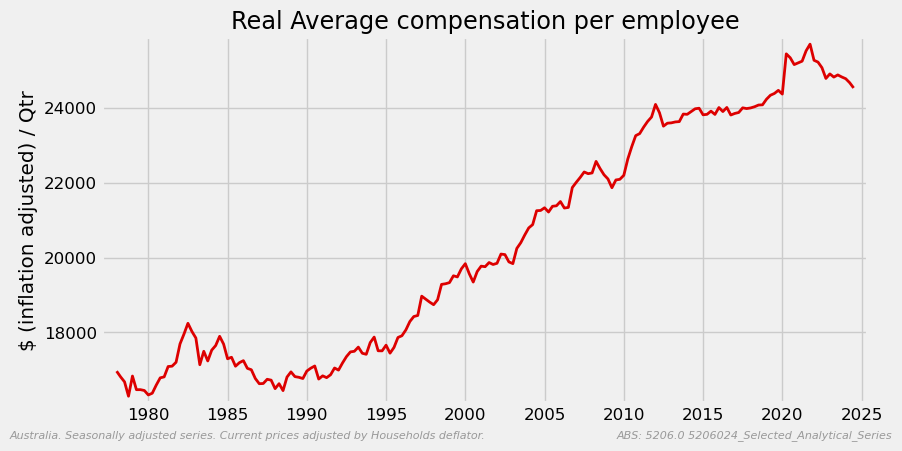

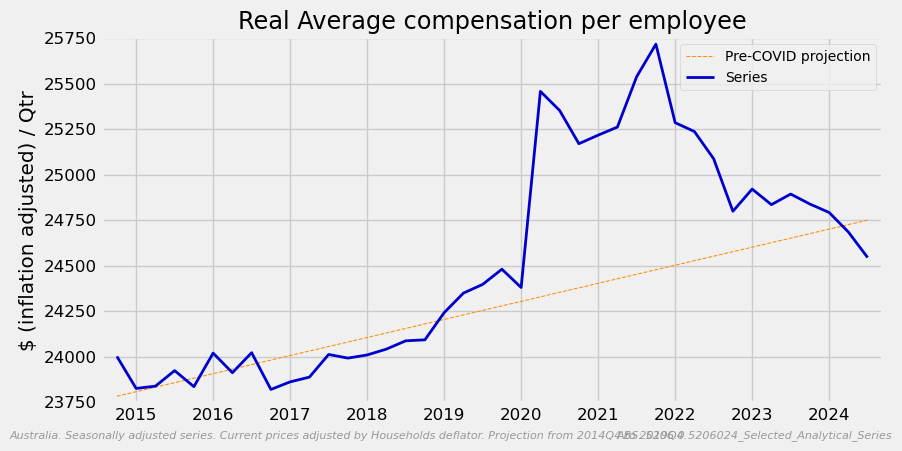

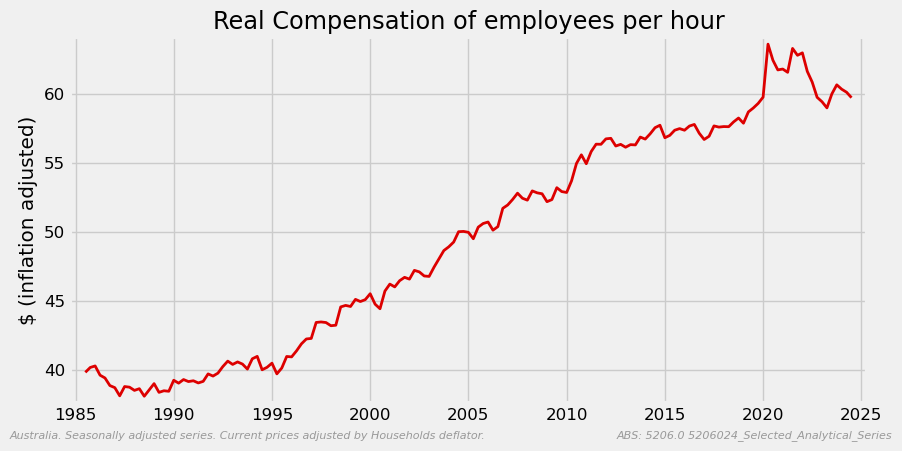

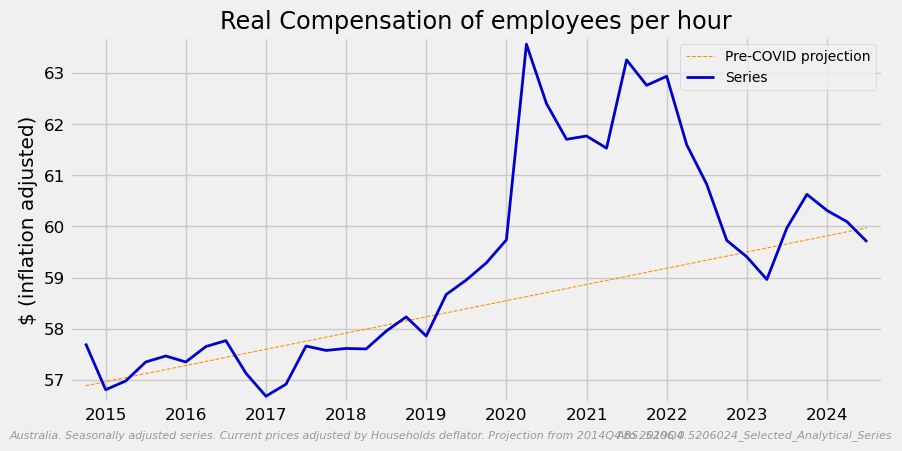

In [29]:
def real_wages(deflators: dict[str, pd.Series]) -> None:
    """Plot real wages."""

    table = "5206024_Selected_Analytical_Series"
    data = abs_dict[table]
    series_type = "Seasonally Adjusted"
    price_type = "Current Prices"
    dids = [
        "Average compensation per employee: Current prices ;",
        "Compensation of employees per hour: Current prices ;",
    ]

    for did in dids:
        deflator = "Households"
        row = meta[
            (meta[mc.table] == table)
            & (meta[mc.stype] == series_type)
            & (meta[mc.did] == did)
        ].iloc[0]
        series_id, units, did = row[mc.id], row[mc.unit], row[mc.did]
        series = (data[series_id] / deflators[deflator]).dropna()
        title = did.split(":")[0].strip()
        series.name = title

        suffix = "" if "per hour" in did else " / Qtr"
        common = {
            "title": f"Real {title}",
            "ylabel": f"{units} (inflation adjusted){suffix}",
            "rfooter": f"{source} {table}",
            "lfooter": f"Australia. {series_type.capitalize()} series. "
            f"{price_type.capitalize()} adjusted by {deflator} deflator. ",
            "pre_tag": "wages-",
            "show": True,
            "file_type": FILE_TYPE,
        }

        line_plot(
            series,
            width=2,
            **common,
        )

        plot_covid_recovery(
            series,
            tags="covid",
            **common,
        )


real_wages(DEFLATORS)

### Wages per capita (calculated from GDP income)

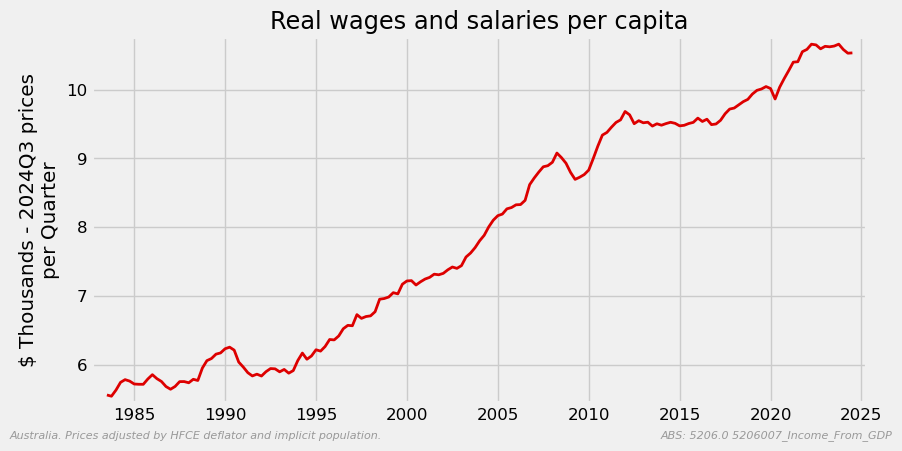

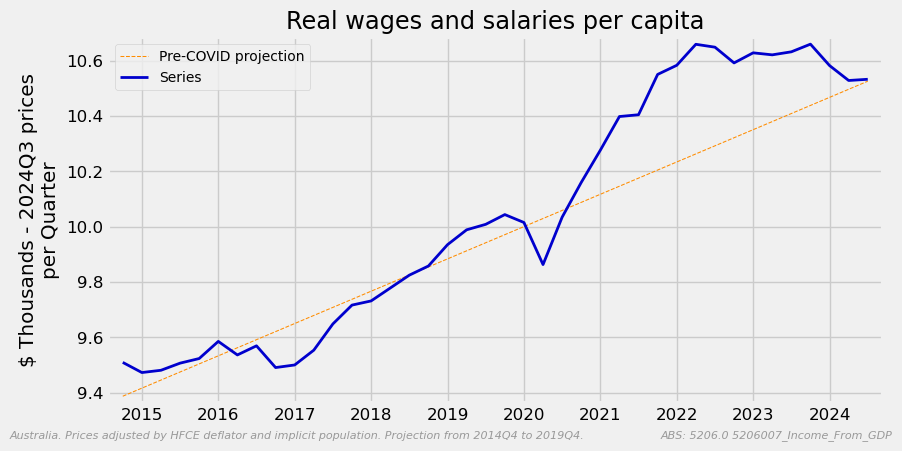

In [30]:
def wages_per_capita() -> None:
    """Plot real wages per capita."""

    # get wages
    income_tab = "5206007_Income_From_GDP"
    selector = {
        income_tab: mc.table,
        "Compensation of employees - Wages and salaries ;": mc.did,
        "Seasonally Adjusted": mc.stype,
    }
    _table, s_id, wage_units = ra.find_abs_id(meta, selector, verbose=False)
    wages = abs_dict[income_tab][s_id]

    # get HFCE implicit price deflator
    ipd_tab = "5206005_Expenditure_Implicit_Price_Deflators"
    selector = {
        ipd_tab: mc.table,
        "Households ;  Final consumption expenditure ;": mc.did,
        "Seasonally Adjusted": mc.stype,
    }
    table, s_id, _ipd_units = ra.find_abs_id(meta, selector, verbose=False)
    ipd = abs_dict[ipd_tab][s_id]
    ipd = ipd / ipd.iloc[-1]  # rebase

    # get population
    kags = "5206001_Key_Aggregates"
    selector = {
        kags: mc.table,
        "Gross domestic product: Current prices ;": mc.did,
        "Original": mc.stype,
        "$": mc.unit,
    }
    table, s_id, _gdp_units = ra.find_abs_id(meta, selector, verbose=False)
    gdp = abs_dict[kags][s_id]
    selector["GDP per capita: Current prices ;"] = mc.did
    del selector["Gross domestic product: Current prices ;"]
    del selector["$"]
    table, s_id, _gdp_pc_units = ra.find_abs_id(meta, selector, verbose=False)
    gdp_pc = abs_dict[kags][s_id]
    population = gdp / gdp_pc * 1_000_000

    # calulate real wages per capita
    real_wages_pc = wages / population / ipd
    real_wages_pc, unit = ra.recalibrate(real_wages_pc, wage_units)

    common = {
        "rfooter": f"{source} {income_tab}",
        "lfooter": "Australia. Prices adjusted by HFCE deflator and implicit population. ",
        "pre_tag": "wages-",
        "show": True,
        "file_type": FILE_TYPE,
        "title": "Real wages and salaries per capita",
        "ylabel": f"{unit} - {population.index[-1]} prices\nper Quarter",
    }

    line_plot(
        real_wages_pc,
        width=2,
        **common,
    )

    plot_covid_recovery(
        real_wages_pc,
        tags="covid",
        **common,
    )


wages_per_capita()

## Watermark

In [31]:
# watermark
%load_ext watermark
%watermark --python --machine --conda --iversions --watermark

Python implementation: CPython
Python version       : 3.12.8
IPython version      : 8.31.0

conda environment: 313

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.2.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

pandas : 2.2.3
readabs: 0.0.24
numpy  : 1.26.4
re     : 2.2.1

Watermark: 2.5.0



In [32]:
print("Finished")

Finished
